# Creating Initial and boundary conditions for ASTE-BLING

We're going to use GLODAPv2 observations when available and results from a global bling run for Fe, DON and DOP.

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 1. Datasets

For observations we use GLODAPv2:

In [3]:
glodap2dir = '/local/data/artemis/observations/GLODAP_v2/originals/'

For all the rest, we use a global bling run:

In [4]:
global_blingdir = '/local/data/artemis/workspace/rdussin/ASTE/global_BLINGv2/'

In [5]:
glodap = xr.open_mfdataset(glodap2dir + '*.nc', compat='minimal')

In [6]:
glodap

<xarray.Dataset>
Dimensions:              (depth_surface: 33, lat: 180, lon: 360, snr: 1)
Coordinates:
  * lon                  (lon) float64 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: depth_surface, snr
Data variables:
    Cant                 (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Cant_error           (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    Cant_relerr          (depth_surface, lat, lon) float64 dask.array<shape=(33, 180, 360), chunksize=(33, 180, 360)>
    SnR                  (snr) float64 dask.array<shape=(1,), chunksize=(1,)>
    CL                   (snr) float64 dask.array<shape=(1,), chunksize=(1,)>
    Depth                (depth_surface) float64 dask.array<shape=(33,), chunksize=(33,)>
    NO3                  (depth_surface, lat, lon) float64 dask.array<sha

In [7]:
# convert units from umol/kg to mol/m3
glodap['TCO2']   = glodap['TCO2']   * 1035. / 1.0e+6
glodap['TAlk']   = glodap['TAlk']   * 1035. / 1.0e+6
glodap['oxygen'] = glodap['oxygen'] * 1035. / 1.0e+6
glodap['NO3']    = glodap['NO3']    * 1035. / 1.0e+6
glodap['PO4']   = glodap['PO4']     * 1035. / 1.0e+6

In [8]:
# since GLODAP has only annual values, we take the annual mean for the global BLING run as well
# to be consistent
global_bling = xr.open_dataset(global_blingdir + 'C1p5.control.3201-3300.ocean_bling_avg_clim.nc')

In [9]:
global_bling

<xarray.Dataset>
Dimensions:           (nv: 2, st_edges_ocean: 29, st_ocean: 28, time: 1, xt_ocean: 120, yt_ocean: 80)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -283.5 -280.5 -277.5 ... 67.5 70.5 73.5
  * yt_ocean          (yt_ocean) float64 -79.5 -76.53 -73.6 ... 85.24 88.41
  * time              (time) object 3201-07-01 17:00:00
  * nv                (nv) float64 1.0 2.0
  * st_ocean          (st_ocean) float64 5.072 15.21 ... 4.808e+03 5.321e+03
  * st_edges_ocean    (st_edges_ocean) float64 0.0 10.14 ... 5.065e+03 5.579e+03
    geolat_t          (yt_ocean, xt_ocean) float32 ...
    geolon_t          (yt_ocean, xt_ocean) float32 ...
Data variables:
    area_t            (yt_ocean, xt_ocean) float32 ...
    chl               (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    diaz              (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    expkT             (time, st_ocean, yt_ocean, xt_ocean) float32 ...
    fdvm              (time, st_ocean, yt_ocean, xt_ocean) f

In [10]:
# convert from MOM BLING to MITgcm BLING units (mol/kg -> mol/m3)
global_bling['n_org'] = global_bling['n_org'] * 1035.
global_bling['p_org'] = global_bling['p_org'] * 1035.
global_bling['fed']   = global_bling['fed'] * 1035.

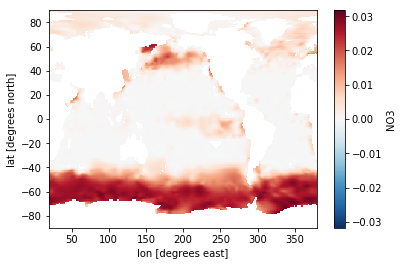

In [11]:
glodap['NO3'].isel(depth_surface=0).plot()

We need to fill part of the pacific for the interpolation not to screw up the Gulf of Mexico

In [12]:
surfno3 = glodap['NO3'].isel(depth_surface=0)
lsm = xr.ones_like(surfno3)
lsm = lsm.where(surfno3.fillna(-9999) != -9999)
lsm = lsm.fillna(0)
lsm.name = 'lsm'
lsm.attrs = ''

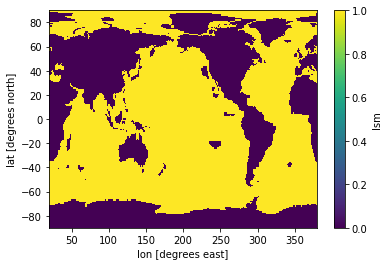

In [13]:
lsm.plot()

In [14]:
def mask_ocean_box(lsm, imin, imax, jmin, jmax, iseed=None, jseed=None):
    """ mask some rectangular section of the ocean
    
    PARAMETERS:
    -----------
    lsm: xarray dataarray
    
    RETURNS:
    --------
    mask: xarray dataarray
    
    """
    
    from scipy.ndimage import binary_dilation
    
    nitermax=1e9
    # let's go into numpy's world
    lsmbox = lsm.transpose(*('lat', 'lon')).values
    lsmbox[jmin,imin:imax] = 0
    lsmbox[jmax,imin:imax] = 0
    lsmbox[jmin:jmax,imin] = 0
    lsmbox[jmin:jmax,imax] = 0
    
    if iseed is None:
        iseed = 0.5 * (imin + imax)
    if jseed is None:
        jseed = 0.5 * (jmin + jmax)
        
    mask_init = np.zeros(lsmbox.shape)
    mask_init[int(jseed), int(iseed)] = 1
    
    mask_old = mask_init.copy()

    for kk in np.arange(nitermax):
        #  use binary dilatation to spread plume
        mask_new = binary_dilation(mask_old)
        #  correct spreading with land/sea mask
        mask_new = mask_new * lsmbox
        #  stop if we converged
        if (mask_new == mask_old).all():
            break
        # update array
        mask_old = mask_new.copy()
        # WARNING: did not converge
        if kk == nitermax-1:
            warnings.warn('spreading did not converge')

    mask = xr.zeros_like(lsm)
    mask.values = mask_new
    return mask
    

In [15]:
mask = mask_ocean_box(lsm, 0, 270, 0, 130, iseed=None, jseed=None)
#
#plt.pcolormesh(lsmbox)

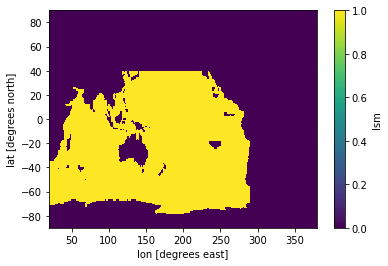

In [16]:
mask.plot()

In [17]:
glodap = glodap.where(mask != 1).where(glodap.lat > -35)

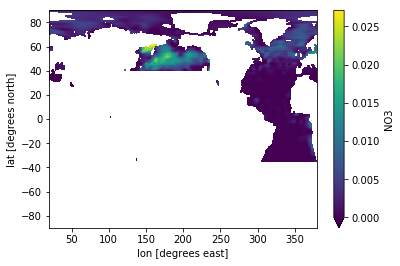

In [18]:
glodap['NO3'].isel(depth_surface=0).plot(vmin=0)

## 2. ASTE Grid

We need to load the ASTE grid to remap to it, first the horizontal+vertical from the Release1. Then we're going
to overwrite XC and YC with the full grid from input files:

In [19]:
datadir_aste = '/local/data/artemis/simulations/ASTE/r1/'
md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste_out = xmitgcm.open_mdsdataset(datadir_aste + 'diags/', iters=[], 
                                   prefix=[''], grid_dir=datadir_aste + 'grid/',
                                   geometry='llc', nx=270, extra_metadata=md)

In [20]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

In [21]:
aste_grid = aste_out.copy()
aste_grid['XC'] = aste_raw['XC']
aste_grid['YC'] = aste_raw['YC']

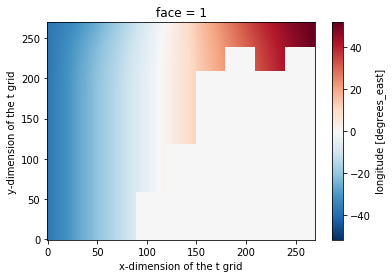

In [22]:
aste_out['XC'].sel(face=1).plot()

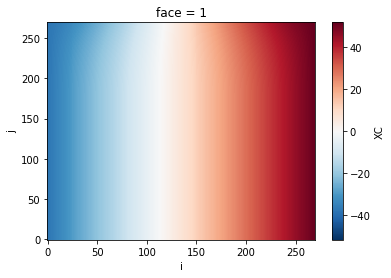

In [23]:
aste_grid['XC'].sel(face=1).plot()

## 3. GLODAP

### 3.1 Extrapolation

In [24]:
glodap_drowned = xr.Dataset()
drowned_no3 = MITgcm_recipes.regridding.drown_field(glodap, 'NO3', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
glodap_drowned.update({'NO3': drowned_no3['NO3']})

<xarray.Dataset>
Dimensions:  (depth_surface: 33, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface
Data variables:
    NO3      (depth_surface, lat, lon) float64 0.0005061 0.0005099 ... 0.02295

In [25]:
# phosphate
drowned_po4 = MITgcm_recipes.regridding.drown_field(glodap, 'PO4', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
glodap_drowned.update({'PO4': drowned_po4['PO4']})

# oxygen
drowned_o2 = MITgcm_recipes.regridding.drown_field(glodap, 'oxygen', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
glodap_drowned.update({'oxygen': drowned_o2['oxygen']})

# DIC
drowned_dic = MITgcm_recipes.regridding.drown_field(glodap, 'TCO2', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
glodap_drowned.update({'TCO2': drowned_dic['TCO2']})

# Alkalinity
drowned_alk = MITgcm_recipes.regridding.drown_field(glodap, 'TAlk', dims_drown=['lat', 'lon'], 
                                                     mask=None, periodicity=0)
glodap_drowned.update({'TAlk': drowned_alk['TAlk']})

<xarray.Dataset>
Dimensions:  (depth_surface: 33, lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface
Data variables:
    NO3      (depth_surface, lat, lon) float64 0.0005061 0.0005099 ... 0.02295
    PO4      (depth_surface, lat, lon) float64 0.0001437 0.0001438 ... 0.001537
    oxygen   (depth_surface, lat, lon) float64 0.24 0.24 0.24 ... 0.2589 0.2588
    TCO2     (depth_surface, lat, lon) float64 2.109 2.109 2.109 ... 2.279 2.279
    TAlk     (depth_surface, lat, lon) float64 2.417 2.417 2.417 ... 2.435 2.435

### 3.2 Vertical interpolation

In [26]:
glodap_drowned['Depth_column'] = glodap['Depth'].sel(lon=359.5, lat=-10.5)

In [27]:
glodap_drowned['Depth_column'].values

array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,
        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2500.,
       3000., 3500., 4000., 4500., 5000., 5500.])

In [28]:
# Tpoint
glodap_drowned_z = MITgcm_recipes.vertical_interpolation(glodap_drowned, aste_grid['Z'], ['NO3', 'PO4', 'oxygen', 'TCO2', 'TAlk'],
                                                         lonvar='lon', latvar='lat',
                                                         depth_varin='Depth_column',
                                                         timevar=None)

In [29]:
glodap_drowned_z

<xarray.Dataset>
Dimensions:  (k: 50, lat: 180, lon: 360)
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
    drF      (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    PHrefC   (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
Data variables:
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    NO3      (k, lat, lon) float64 0.0005109 0.0005146 ... 0.02294 0.02295
    PO4      (k, lat, lon) float64 0.0001435 0.0001435 ... 0.001537 0.001537
    oxygen   (k, lat, lon) float64 0.2397 0.2397 0.2397 ... 0.2589 0.2589 0.2588
    TCO2     (k, lat, lon) float64 2.108 2.108 2.108 2.108 ... 2.279 2.279 2.279
    TAlk     (k, lat, lon) float64 2.418 2.418 2.418 2.418 ... 2.435 2.435 2.435

In [30]:
glodap_drowned['lon']

<xarray.DataArray 'lon' (lon: 360)>
array([ 20.5,  21.5,  22.5, ..., 377.5, 378.5, 379.5])
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
Attributes:
    units:        degrees east
    Description:  This number represents the mid-point of the 1x1 degree grid...

We also need to roll the data from -180 to 180

In [31]:
def geo_roll_glodap_to_180(ds, londim):
    ind = (np.abs(ds[londim].values-180.)).argmin()
    ds = ds.roll(**{londim: -ind-1})
    datalon = np.mod(ds[londim].values, 360)
    datalon[np.where(datalon > 180)] -= 360
    ds[londim] = datalon
    return ds

In [32]:
glodap_drowned_z180 = geo_roll_glodap_to_180(glodap_drowned_z, 'lon')

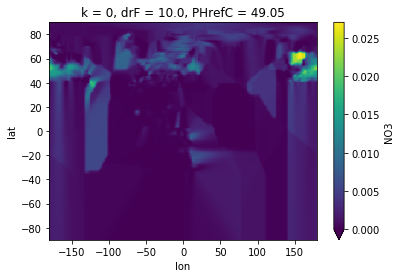

In [33]:
glodap_drowned_z180['NO3'].isel(k=0).plot(vmin=0)

In [34]:
glodap_drowned_z180['lon']

<xarray.DataArray 'lon' (lon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

### 3.3 Horizontal interpolation

In [35]:
mask_face2 = np.ones((270, 270))
mask_face2[130:140,130:140] = 0
mask_north_pole = {2: mask_face2}

In [36]:
regrid_T = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(glodap_drowned_z180, aste_grid, 
                                                         ['NO3', 'PO4', 'oxygen', 'TCO2', 'TAlk'], 
                                                         method='bilinear',
                                                         lonname='lon', latname='lat', point='T', 
                                                         faces2blend=[2], blend_mask=mask_north_pole, 
                                                         periodic=True, reuse_weights=False)

Overwrite existing file: regrid_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Creating nearest neighbor weights for face 2
Overwrite existing file: backup_regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face5.nc 
 You can set reuse_weights=True to save computing time.
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2


In [37]:
regrid_T

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, j: 270, k: 50)
Coordinates:
    drF      (k) >f4 10.0 10.0 10.0 10.0 10.0 ... 364.5 387.5 410.5 433.5 456.5
    PHrefC   (k) >f4 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * face     (face) int64 0 1 2 3 4 5
Data variables:
    NO3      (face, k, j, i) float64 0.0007806 0.0007806 0.0007806 ... 0.0 0.0
    PO4      (face, k, j, i) float64 4.782e-05 4.782e-05 4.782e-05 ... 0.0 0.0
    oxygen   (face, k, j, i) float64 0.2108 0.2108 0.2108 0.2108 ... 0.0 0.0 0.0
    TCO2     (face, k, j, i) float64 2.015 2.015 2.015 2.015 ... 0.0 0.0 0.0 0.0
    TAlk     (face, k, j, i) float64 2.337 2.337 2.337 2.337 ... 0.0 0.0 0.0 0.0

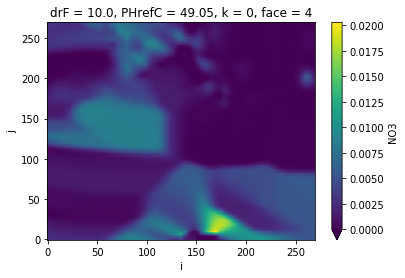

In [38]:
regrid_T['NO3'].sel(face=4, k=0).plot(vmin=0)

### 3.4 Masking

To create the initial condition, we mask the results of the interpolation by the model's grid:

In [39]:
masked_no3 = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.NO3, aste_grid, point='T')

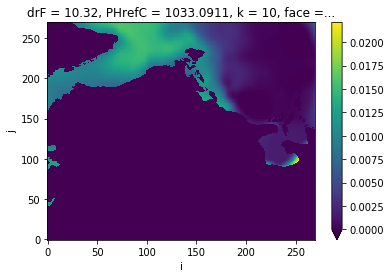

In [40]:
masked_no3.sel(face=4, k=10).plot(vmin=0)

Do the same for the other variables:

In [41]:
masked_po4 = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.PO4, aste_grid, point='T')
masked_o2  = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.oxygen, aste_grid, point='T')
masked_dic = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.TCO2, aste_grid, point='T')
masked_alk = MITgcm_recipes.regridding.mask_output_zeros(regrid_T.TAlk, aste_grid, point='T')

## 4. Global BLING run

### 4.1 Extrapolation

In [42]:
globling_drowned = xr.Dataset()
drowned_fed = MITgcm_recipes.regridding.drown_field(global_bling, 'fed', dims_drown=['yt_ocean', 'xt_ocean'], 
                                                     mask=None, periodicity=0)
globling_drowned.update({'fed': drowned_fed['fed']})

<xarray.Dataset>
Dimensions:   (st_ocean: 28, time: 1, xt_ocean: 120, yt_ocean: 80)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -283.5 -280.5 -277.5 -274.5 ... 67.5 70.5 73.5
  * yt_ocean  (yt_ocean) float64 -79.5 -76.53 -73.6 -70.77 ... 82.16 85.24 88.41
    geolon_t  (yt_ocean, xt_ocean) float32 -283.5 -280.5 ... 74.406 74.80236
    geolat_t  (yt_ocean, xt_ocean) float32 -79.5 -79.5 ... 67.94256 66.79687
  * time      (time) object 3201-07-01 17:00:00
  * st_ocean  (st_ocean) float64 5.072 15.21 25.36 ... 4.808e+03 5.321e+03
Data variables:
    fed       (time, st_ocean, yt_ocean, xt_ocean) float64 3.484e-07 ... 2.22e-07

In [43]:
# DON
drowned_don = MITgcm_recipes.regridding.drown_field(global_bling, 'n_org', dims_drown=['yt_ocean', 'xt_ocean'], 
                                                    mask=None, periodicity=0)
globling_drowned.update({'n_org': drowned_don['n_org']})

# oxygen
drowned_dop = MITgcm_recipes.regridding.drown_field(global_bling, 'p_org', dims_drown=['yt_ocean', 'xt_ocean'], 
                                                    mask=None, periodicity=0)
globling_drowned.update({'p_org': drowned_dop['p_org']})

<xarray.Dataset>
Dimensions:   (st_ocean: 28, time: 1, xt_ocean: 120, yt_ocean: 80)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -283.5 -280.5 -277.5 -274.5 ... 67.5 70.5 73.5
  * yt_ocean  (yt_ocean) float64 -79.5 -76.53 -73.6 -70.77 ... 82.16 85.24 88.41
    geolon_t  (yt_ocean, xt_ocean) float32 -283.5 -280.5 ... 74.406 74.80236
    geolat_t  (yt_ocean, xt_ocean) float32 -79.5 -79.5 ... 67.94256 66.79687
  * time      (time) object 3201-07-01 17:00:00
  * st_ocean  (st_ocean) float64 5.072 15.21 25.36 ... 4.808e+03 5.321e+03
Data variables:
    fed       (time, st_ocean, yt_ocean, xt_ocean) float64 3.484e-07 ... 2.22e-07
    n_org     (time, st_ocean, yt_ocean, xt_ocean) float64 0.0008701 ... 7.408e-08
    p_org     (time, st_ocean, yt_ocean, xt_ocean) float64 3.996e-05 ... 1.82e-08

### 4.2 Vertical interpolation

In [44]:
globling_drowned_z = MITgcm_recipes.vertical_interpolation(globling_drowned, aste_grid['Z'], ['fed', 'n_org', 'p_org'],
                                                           lonvar='xt_ocean', latvar='yt_ocean',
                                                           depth_varin='st_ocean',
                                                           timevar=None)

In [45]:
# add back coordinates into dataset
globling_drowned_z = globling_drowned_z.assign_coords(geolon_t=globling_drowned['geolon_t'], geolat_t=globling_drowned['geolat_t'])

### 4.3 Horizontal interpolation

In [46]:
regrid_T2 = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(globling_drowned_z, aste_grid, 
                                                          ['n_org', 'p_org', 'fed'], 
                                                          method='bilinear',
                                                          lonname='geolon_t', latname='geolat_t', point='T', 
                                                          faces2blend=[2], blend_mask=mask_north_pole, 
                                                          periodic=True, reuse_weights=False)

Overwrite existing file: regrid_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Creating nearest neighbor weights for face 2
Overwrite existing file: backup_regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face5.nc 
 You can set reuse_weights=True to save computing time.
running nn regridding for face 2
running nn regridding for face 2
running nn regridding for face 2


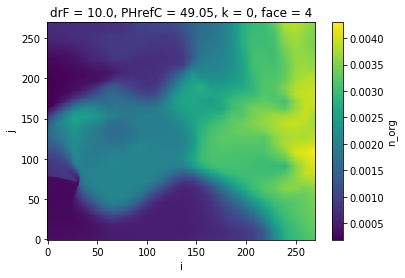

In [63]:
regrid_T2['n_org'].isel(face=4, k=0).plot()

### 4.4 Masking

In [48]:
masked_don = MITgcm_recipes.regridding.mask_output_zeros(regrid_T2.n_org, aste_grid, point='T')

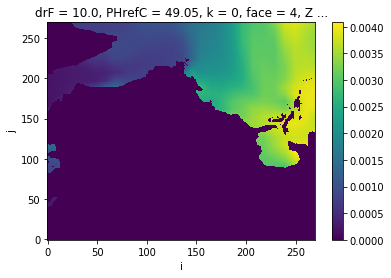

In [64]:
masked_don.isel(face=4, k=0).plot()

In [49]:
masked_dop = MITgcm_recipes.regridding.mask_output_zeros(regrid_T2.p_org, aste_grid, point='T')
masked_fed = MITgcm_recipes.regridding.mask_output_zeros(regrid_T2.fed, aste_grid, point='T')

## 5. Convert to binary

First let's save all the fields in individual files that can be used for initial conditions in data.ptracers

In [50]:
dirglodap_aste = '/local/data/artemis/workspace/rdussin/ASTE/INPUTS/inputs_bgc_from_GLODAPv2/new/'
dirglobling_aste = '/local/data/artemis/workspace/rdussin/ASTE/INPUTS/inputs_bgc_from_global_BLINGv2/new/'

In [51]:
# DIC
facets_dic = xmitgcm.utils.rebuild_llc_facets(masked_dic, md)
compact_dic = xmitgcm.utils.llc_facets_2d_to_compact(facets_dic, md)
xmitgcm.utils.write_to_binary(compact_dic, dirglodap_aste + 'DIC_GLODAPv2_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# Alk
facets_alk = xmitgcm.utils.rebuild_llc_facets(masked_alk, md)
compact_alk = xmitgcm.utils.llc_facets_2d_to_compact(facets_alk, md)
xmitgcm.utils.write_to_binary(compact_alk, dirglodap_aste + 'ALK_GLODAPv2_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# O2
facets_o2 = xmitgcm.utils.rebuild_llc_facets(masked_o2, md)
compact_o2 = xmitgcm.utils.llc_facets_2d_to_compact(facets_o2, md)
xmitgcm.utils.write_to_binary(compact_o2, dirglodap_aste + 'O2_GLODAPv2_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))


# NO3
facets_no3 = xmitgcm.utils.rebuild_llc_facets(masked_no3, md)
compact_no3 = xmitgcm.utils.llc_facets_2d_to_compact(facets_no3, md)
xmitgcm.utils.write_to_binary(compact_no3, dirglodap_aste + 'NO3_GLODAPv2_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# PO4
facets_po4 = xmitgcm.utils.rebuild_llc_facets(masked_po4, md)
compact_po4 = xmitgcm.utils.llc_facets_2d_to_compact(facets_po4, md)
xmitgcm.utils.write_to_binary(compact_po4, dirglodap_aste + 'PO4_GLODAPv2_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# Fed
facets_fed = xmitgcm.utils.rebuild_llc_facets(masked_fed, md)
compact_fed = xmitgcm.utils.llc_facets_2d_to_compact(facets_fed, md)
xmitgcm.utils.write_to_binary(compact_fed, dirglobling_aste + 'Fe_global_BLING_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# DON
facets_don = xmitgcm.utils.rebuild_llc_facets(masked_don, md)
compact_don = xmitgcm.utils.llc_facets_2d_to_compact(facets_don, md)
xmitgcm.utils.write_to_binary(compact_don, dirglobling_aste + 'DON_global_BLING_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

# DOP
facets_dop = xmitgcm.utils.rebuild_llc_facets(masked_dop, md)
compact_dop = xmitgcm.utils.llc_facets_2d_to_compact(facets_dop, md)
xmitgcm.utils.write_to_binary(compact_dop, dirglobling_aste + 'DOP_global_BLING_yearly_ASTE.bin', 
                              dtype=np.dtype('float64'))

Next we can create an zeros file for our river DOC field. If initial data.ptracers is left blank for a given variable, it's initialized at zero so we don't need to make a single file for it (same applies to data.obcs). However we are going to need it in the pickup_tracer file.

In [52]:
compact_rdoc = np.zeros((1350*270*50))

Finally we can concatenate all the compact into a single pickup_ptracer file. The order of the variables matters and must be consistent with data.ptracers and bling.

In [53]:
ptracer = np.concatenate([compact_dic, compact_alk, compact_o2, 
                          compact_no3, compact_po4, compact_fed,
                          compact_don, compact_dop])

In [54]:
xmitgcm.utils.write_to_binary(ptracer, 'pickup_ptracer_ic_bling.data', dtype=np.dtype('float64'))

Now let's make one with the riverdoc:

In [55]:
ptracer_rdoc = np.concatenate([ptracer, compact_rdoc])

In [56]:
xmitgcm.utils.write_to_binary(ptracer, 'pickup_ptracer+rdoc_ic_bling.data', dtype=np.dtype('float64'))

## 6. Open Boundary conditions

While we have all the fields computed let's make open boundary conditions as well:

In [57]:
obcs, obce = MITgcm_recipes.open_boundary.define_obc_aste()
nobcs=1170
nobce=1260
nlevs=50
ntime=1

Southern boundary conditions:

In [58]:
dic_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_dic, obcs, nobcs, nlevs, ntime)
alk_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_alk, obcs, nobcs, nlevs, ntime)
o2_obcs  = MITgcm_recipes.open_boundary.extract_obc_raw(masked_o2,  obcs, nobcs, nlevs, ntime)
no3_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_no3, obcs, nobcs, nlevs, ntime)
po4_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_po4, obcs, nobcs, nlevs, ntime)
fed_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_fed, obcs, nobcs, nlevs, ntime)
don_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_don, obcs, nobcs, nlevs, ntime)
dop_obcs = MITgcm_recipes.open_boundary.extract_obc_raw(masked_dop, obcs, nobcs, nlevs, ntime)

Eastern boundary conditions:

In [59]:
dic_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_dic, obce, nobce, nlevs, ntime)
alk_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_alk, obce, nobce, nlevs, ntime)
o2_obce  = MITgcm_recipes.open_boundary.extract_obc_raw(masked_o2,  obce, nobce, nlevs, ntime)
no3_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_no3, obce, nobce, nlevs, ntime)
po4_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_po4, obce, nobce, nlevs, ntime)
fed_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_fed, obce, nobce, nlevs, ntime)
don_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_don, obce, nobce, nlevs, ntime)
dop_obce = MITgcm_recipes.open_boundary.extract_obc_raw(masked_dop, obce, nobce, nlevs, ntime)

Let's repeat these fields 12 times to make fake monthly files with the same records over and over:

In [60]:
dic_obcs_monthly = np.repeat(dic_obcs, 12, axis=0)
alk_obcs_monthly = np.repeat(alk_obcs, 12, axis=0)
o2_obcs_monthly  = np.repeat(o2_obcs,  12, axis=0)
no3_obcs_monthly = np.repeat(no3_obcs, 12, axis=0)
po4_obcs_monthly = np.repeat(po4_obcs, 12, axis=0)
fed_obcs_monthly = np.repeat(fed_obcs, 12, axis=0)
don_obcs_monthly = np.repeat(don_obcs, 12, axis=0)
dop_obcs_monthly = np.repeat(dop_obcs, 12, axis=0)

dic_obce_monthly = np.repeat(dic_obce, 12, axis=0)
alk_obce_monthly = np.repeat(alk_obce, 12, axis=0)
o2_obce_monthly  = np.repeat(o2_obce,  12, axis=0)
no3_obce_monthly = np.repeat(no3_obce, 12, axis=0)
po4_obce_monthly = np.repeat(po4_obce, 12, axis=0)
fed_obce_monthly = np.repeat(fed_obce, 12, axis=0)
don_obce_monthly = np.repeat(don_obce, 12, axis=0)
dop_obce_monthly = np.repeat(dop_obce, 12, axis=0)

Write to binary files:

In [61]:
xmitgcm.utils.write_to_binary(dic_obcs_monthly.flatten(), 
                              dirglodap_aste + 'DIC_GLODAP2_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(alk_obcs_monthly.flatten(), 
                              dirglodap_aste + 'ALK_GLODAP2_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(o2_obcs_monthly.flatten(), 
                              dirglodap_aste + 'O2_GLODAP2_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(no3_obcs_monthly.flatten(), 
                              dirglodap_aste + 'NO3_GLODAP2_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(po4_obcs_monthly.flatten(), 
                              dirglodap_aste + 'PO4_GLODAP2_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(fed_obcs_monthly.flatten(), 
                              dirglobling_aste + 'FED_bling_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(don_obcs_monthly.flatten(), 
                              dirglobling_aste + 'DON_bling_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(dop_obcs_monthly.flatten(), 
                              dirglobling_aste + 'DOP_bling_obc_south_annual_12x50x1170_ASTE.bin',
                              dtype=np.dtype('float64'))

In [62]:
xmitgcm.utils.write_to_binary(dic_obce_monthly.flatten(), 
                              dirglodap_aste + 'DIC_GLODAP2_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(alk_obce_monthly.flatten(), 
                              dirglodap_aste + 'ALK_GLODAP2_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(o2_obce_monthly.flatten(), 
                              dirglodap_aste + 'O2_GLODAP2_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(no3_obce_monthly.flatten(), 
                              dirglodap_aste + 'NO3_GLODAP2_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(po4_obce_monthly.flatten(), 
                              dirglodap_aste + 'PO4_GLODAP2_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(fed_obce_monthly.flatten(), 
                              dirglobling_aste + 'FED_bling_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(don_obce_monthly.flatten(), 
                              dirglobling_aste + 'DON_bling_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))

xmitgcm.utils.write_to_binary(dop_obce_monthly.flatten(), 
                              dirglobling_aste + 'DOP_bling_obc_east_annual_12x50x1260_ASTE.bin',
                              dtype=np.dtype('float64'))